In [14]:
import numpy as np
from fluids import H2

Plotting

In [15]:
def turb_outlet_pressure(core_pressure, density, radius, mdot, w, R1, R2, R3, L, T_PM):
    "Returns turbine outlet pressure P1 and SiC inner wall pressure P2"
    dPs = []
    preint = - (w**2)/R2
    for i in range(radius.shape[0]):
        dP = radius[i]**2 * density[i]
        dPs.append(dP)
    P_cent = preint * np.sum(dPs) * np.diff(radius)[0]
    P2 = core_pressure + P_cent # Outlet pressure [MPa]
    PMstate = H2(T=T_PM, P=P2) # Fluid state
    Q= mdot / PMstate.rho # Volumetric flow rate [m^3/s]
    A = 2*np.pi*R3*L # Cross sectional area [m^2]
    vs = Q / A # Darcian velocity [m/s]

    k1 = 5.69771546674471E-12 # for 18% open porosity, 35% total
    k2 = np.exp(-1.71588/(k1**0.08093)) # Correlation from Dey et al.
    P1 = np.sqrt((PMstate.mu*vs/k1 + (PMstate.rho*vs**2)/k2) * 2*P2*(R3-R2) + P2**2) # Inlet pressure to PM [Pa]
    PM_dP =  P1 - P2 # Pressure drop across PM [Pa]
    return P1, P2

In [16]:
def uranium_mass(density, radius, L):
    m = 0
    for i in range(radius.shape[0]):
        dm = density[i] * (2*np.pi*radius[i]) * L
        m += dm * -np.diff(radius)[0]
    return m

In [17]:
from fluids import H2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='Times New Roman',size="10")
mpl.rc('figure', figsize=(4.8,3.6))
mpl.rc('savefig', dpi=800)
mpl.rc('lines', linewidth=1.2)
mpl.rc('axes', grid=True)
mpl.rc('grid', linewidth=0.25)
mpl.rc('mathtext', fontset="dejavuserif")
mpl.rc('xtick.minor', visible=True, size=1.5, width=0.5)
mpl.rc('ytick.minor', visible=True, size=1.5, width=0.5)
plt.rcParams['figure.constrained_layout.use'] =  True

base = {"P_core":10e6,
        "T_channel":450,
        "r1":30e-3,
        "r2":45e-3,
        "r3":49e-3,
        "r4":51e-3,
        "r5":56e-3,
        "d56":8e-3,
        "N":7000,
        "nu_s":0.691,
        "L_CFE":.84,
        "T_core":3700,
        "mdot":.108}

stdlim = [0.5, 2]

# ******************************************
# TODO: if you don't want to plot vs a particular parameter, remove it from `vary`
# TODO: if you want to plot a particular parameter over a range different from others, replace its limits in `vary`
# ******************************************

vary = {"P_core":stdlim,
        #"T_channel":stdlim,
        # "r5":stdlim,
        # "d56":[0.125, 2],
        "N":stdlim,
        # "nu_s":stdlim,
        "L_CFE":stdlim}

labels = {"P_core":"core pressure $P_3$", 
        "T_channel":"channel temperature $T_1$",
        "r5":"case radius $r_5$",
        "d56":"outer channel width $(r_6 - r_5)$",
        "N":"CFE rotation rate $\omega$",
        "nu_s":"turbine sp. speed $\\nu_s$",
        "L_CFE":"CFE length $l$"}

Pvals = dict()
mvals = dict()
xvals = dict()
base_core = H2(P=base["P_core"], T=base["T_core"])      # speed code up by not calculating on every single loop

for key in vary:                    # iterate through properties we want to vary
    props = base.copy()             # reset all properties to base values
    lim = vary[key]                 # relative property value limits
    n_pts = 50                      # number of x-value points to plot to form a smooth curve
    xvals[key] = np.arange(lim[0], lim[1]+1e-5, np.diff(lim)/n_pts)
    Pvals[key] = []
    mvals[key] = []  
    for j in range(len(xvals[key])):
        props[key] = xvals[key][j] * base[key]              # adjust single parameter
        L_total = props["L_CFE"] + 0.1          # compute total length
        if key=="P_core" or key=="T_core":      # check if core state needs adjustment
            core = H2(P=props["P_core"], T=props["T_core"])
        else:
            core = base_core
        omega = props["N"] * np.pi/30           # compute omega
        r6 = props["r5"] + props["d56"]         # compute r6
        d = np.load(f"Better/d_{key}_{j+1}.npy")
        r = np.load(f"Better/r_{key}_{j+1}.npy")
        P1, P2 = turb_outlet_pressure(props["P_core"], d, r, props["mdot"], omega, props["r1"], props["r2"], props["r3"], props["L_CFE"], 1494)
        m = uranium_mass(d, r, props["L_CFE"])
        Pvals[key].append(P1)
        mvals[key].append(m)

d = np.load(f"Better/d_baseline.npy")
r = np.load(f"Better/r_baseline.npy")
omega = base["N"] * np.pi/30
P1, P2 = turb_outlet_pressure(base["P_core"], d, r, base["mdot"], omega, base["r1"], base["r2"], base["r3"], base["L_CFE"], 1494)

m = uranium_mass(d, r, base["L_CFE"])
Pvals["baseline"] = P1
mvals["baseline"] = m
u
np.savez("P1_params.npz", **xvals)
np.savez("P1.npz", **Pvals)
np.savez("uranium_mass.npz", **mvals)

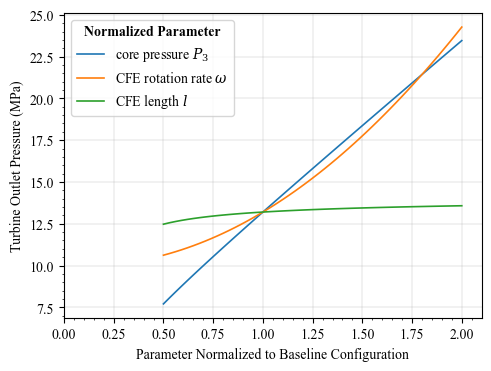

In [18]:
for key in xvals:       # plot each line
    plt.plot(xvals[key], [y/1e6 for y in Pvals[key]], label=labels[key])

plt.legend(title="Normalized Parameter", title_fontproperties={"family": "Times New Roman:bold"})
plt.xlabel("Parameter Normalized to Baseline Configuration")
plt.ylabel("Turbine Outlet Pressure (MPa)")
plt.xlim(0,2.1)

# ******************************************
# TODO: update figure name
# ******************************************
plt.savefig("turbine_pressure.svg")
plt.show()